# A preliminary investigation of PULSR neutronics

The goal here is to pull some nuclear data, and assign a figure of merit to compare two different nuclear fuels for
our reactor. The NASA Kilopower folks have chosen UMo (9%w.t. molybdenum uranium). We propose Pu-Fe eutectic (9.2%w.t. iron) as a nuclear fuel for the fast spectrum. A figure of merit that penalizes absorbtion and merits high fission cross section was devised: $(\nu \Sigma_f)^2 / \Sigma_a$.

The plutonium is assumed to be weapons grade, while the uranium gets assumed to be 93% enriched, having its minor isotopes like 234 calculated automatically by openmc. Notably, openmc gives a warning on the U234 content approximation not working on HEU, so this could skew the result.

In [2]:
%matplotlib inline
import os
from pprint import pprint
import shutil
import subprocess
import urllib.request

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib.patches import Rectangle

import openmc.data
import openmc

In [3]:
os.environ['OPENMC_CROSS_SECTIONS']='/home/gavin/code/openmc/scripts/cross_sections.xml'

In [4]:
# let's load some of the relevant isotopes for the problem:
datadir = '/home/gavin/code/openmc/scripts/'
pu = [openmc.data.IncidentNeutron.from_hdf5(datadir+'Pu{}.h5'.format(i)) for i in range(239,243)]
tungIso = [182, 183, 184, 186]
w = [openmc.data.IncidentNeutron.from_hdf5(datadir+'W{}.h5'.format(i)) for i in tungIso] # 180 missing
ta = openmc.data.IncidentNeutron.from_hdf5(datadir+'Ta181.h5') # neglect ta-180
be = openmc.data.IncidentNeutron.from_hdf5(datadir+'Be9.h5')
iroIso = [54, 56, 57, 58]
iron = [openmc.data.IncidentNeutron.from_hdf5(datadir+'Fe{}.h5'.format(i)) for i in iroIso]
h = openmc.data.IncidentNeutron.from_hdf5(datadir+'H1.h5')

In [5]:
# unpack some
pu239, pu240, pu241, pu242 = tuple(pu)
w182, w183, w184, w186 = tuple(w)
fe54, fe56, fe57, fe58 = tuple(iron)

In [6]:
# gallium may matter:
ga69 = openmc.data.IncidentNeutron.from_hdf5(datadir+'Ga69.h5')
ga71 = openmc.data.IncidentNeutron.from_hdf5(datadir+'Ga71.h5')

In [7]:
# molybdenum and uranium:
moIso = [92, 94, 95, 96, 97, 98,100]
moly = [openmc.data.IncidentNeutron.from_hdf5(datadir+'Mo{}.h5'.format(i)) for i in moIso]
u235 = openmc.data.IncidentNeutron.from_hdf5(datadir+'U235.h5')
u238 = openmc.data.IncidentNeutron.from_hdf5(datadir+'U238.h5')

For comparison, let's investigate the ratio of macroscopic neutron production cross section to macroscopic absorbtion cross section for iron-plutonium eutectic and also U-Moly. A good FoM for small critical mass would be
$(\nu \Sigma_f)^2 / \Sigma_a$ because it preferentially favors high fission cross section combined with penalizing high absorbtion.

In [21]:
# interpolate Pu-fuel cross sections onto the Pu-239 energy grid:
energyPu = pu239.energy['600K']
pufe = openmc.Material()
umoly = openmc.Material()

In [22]:
umoly.set_density('g/cm3', 17.0) # from IAEA Oliveira, see Zotero
# calculate PuFe density if 1% of the trivalent part (Pu) is gallium.
# pu density:
# calc density of trivalent part of mix, then add in iron density:
pufe.set_density('g/cm3',100./((99./((1.-.092)*16.)) + 1./5.91)+.092*16.)

In [11]:
purewgpu = openmc.Material()
purewgpu.add_nuclide('Pu238',.00012,percent_type='wo')
purewgpu.add_nuclide('Pu239',.938,percent_type='wo')
purewgpu.add_nuclide('Pu240',.058,percent_type='wo')
purewgpu.add_nuclide('Pu241',.0035,percent_type='wo')
purewgpu.add_nuclide('Pu242',.00022,percent_type='wo')
purewgpu.set_density('g/cm3',1.)

In [19]:
# get atom fractions of each isotope in WG Pu
dictx = purewgpu.get_nuclide_atom_densities()
adenssum = 0.0
for _, (nuc,ndens) in dictx.items():
    adenssum += ndens
puAdensDict = []
for _, (nuc,ndens) in dictx.items():
    print(nuc,ndens/adenssum)
    puAdensDict.append(ndens/adenssum)

Nuclide    -    Pu238
 0.000120557652199
Nuclide    -    Pu239
 0.93840665405
Nuclide    -    Pu240
 0.0577830288097
Nuclide    -    Pu241
 0.00347239788619
Nuclide    -    Pu242
 0.000217361602085


In [23]:
pufe.add_element('Fe',9.2,percent_type='ao')
pufe.add_element('Ga',(100.-9.2)*.01,percent_type='wo') # 1 w.t.% gallium in Pu
pufrac = (100.-9.2)
# WG Pu: (maybe)
pufe.add_nuclide('Pu238',pufrac*puAdensDict[0],percent_type='ao')
pufe.add_nuclide('Pu239',pufrac*puAdensDict[1],percent_type='ao')
pufe.add_nuclide('Pu240',pufrac*puAdensDict[2],percent_type='ao')
pufe.add_nuclide('Pu241',pufrac*puAdensDict[3],percent_type='ao')
pufe.add_nuclide('Pu242',pufrac*puAdensDict[4],percent_type='ao')

In [ ]:
pufe.

In [71]:
umoly.add_element('U',91.,percent_type='wo',enrichment=93.)
umoly.add_element('Mo',9.,percent_type='wo')

/usr/local/lib/python3.5/dist-packages/openmc-0.9.0-py3.5-linux-x86_64.egg/openmc/material.py:598: UserWarning: A uranium enrichment of 93.0 was given for Material ID="4". OpenMC assumes the U234/U235 mass ratio is constant at 0.008, which is only valid at low enrichments. Consider setting the isotopic composition manually for enrichments over 5%.
  warnings.warn(msg)


In [72]:
umolyAdensDict = umoly.get_nuclide_atom_densities()
umolyNuclides = umoly.get_nuclides()
pufeAdensDict = pufe.get_nuclide_atom_densities()
pufeNuclides = pufe.get_nuclides()

In [73]:
uEnergy = u235.energy['600K'] # u 235 energy grid

In [182]:
def getSigmaA(nuclib, adendict):
    """ gets macroscopic absorbtion cross section"""
    sigA = np.zeros(len(energyPu))
    
    for nucname, nuclib in nuclib:
        sigA += nuclib[102].xs['600K'](energyPu) * adendict[openmc.Nuclide(nucname)][1]
        
    return sigA

def getSigmaAFromMaterial(material, datadir):
    """ getSigmaA, but vastly improved. just pass in a material."""
    nuclist = material.get_nuclides()
    adens = material.get_nuclide_atom_densities()
    sigA = np.zeros(len(energyPu))
    
    for nuc in nuclist:
        datlib = openmc.data.IncidentNeutron.from_hdf5(datadir+'{}.h5'.format(nuc))
        sigA += datlib[102].xs['600K'](energyPu) * adens[openmc.Nuclide(nuc)][1]
        
    return sigA
    

def getNSF(fissList, adensDict):
    """gets \nu \Sigma_f for a material given atom densities and nuclides"""
    nsf = np.zeros(len(energyPu))

    for nucname, nuclib in fissile:
        prodlist = nuclib[18].products

        # get neutrons per fission
        nu = np.zeros(len(energyPu))
        for product in prodlist:
            if product.emission_mode=='prompt' and product.particle=='neutron':
                # then this is a prompt fission
                nu += product.yield_(energyPu)
            elif product.emission_mode=='delayed' and product.particle=='neutron':
                # add on delayed neutrons
                nu += product.yield_(energyPu)

        # get \Sigma_f
        sigf = nuclib[18].xs['600K'](energyPu) * adensDict[openmc.Nuclide(nucname)][1]
        nsf += sigf * nu
        
    return nsf


In [178]:
# calculate the macroscopic cross sections of interest:
fissile = [('Pu239',pu239),('Pu240',pu240),('Pu241',pu241),('Pu242',pu242)] # list of name, ACE data lib
pufeNSF = getNSF(fissile, pufeAdensDict)
libdict=[
 ('Pu239',pu239),
 ('Pu240',pu240),
 ('Pu241',pu241),
 ('Pu242',pu242),
 ('Fe54',fe54),
 ('Fe56',fe56),
 ('Fe57',fe57),
 ('Fe58',fe58),
 ('Ga69',ga69),
 ('Ga71',ga71)]
pufeSigA = getSigmaA(libdict, pufeAdensDict)

In [184]:
# now do the same for u-moly
fissile = [('U235',u235),('U238',u238)]
umolyNSF = getNSF(fissile,umolyAdensDict)
umolySigA = getSigmaAFromMaterial(umoly, datadir)

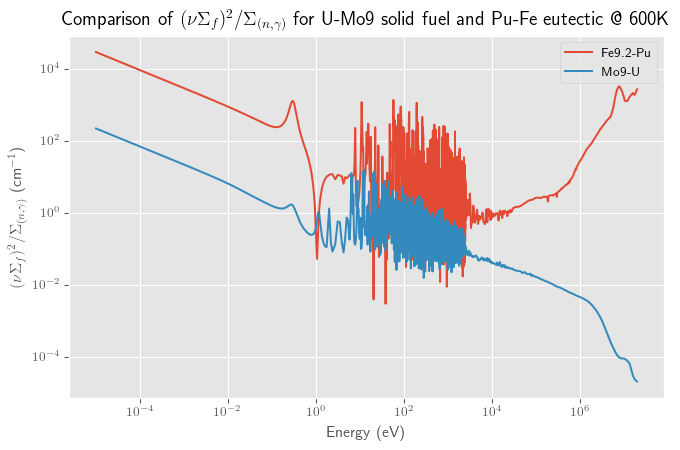

In [192]:
from matplotlib import rc
rc('text', usetex=True)
fig = pl.figure(figsize=(8,5), dpi=96)
ax = fig.add_subplot(111)
pl.style.use('ggplot')
ax.set_title(r'Comparison of $(\nu \Sigma_f)^2/\Sigma_{(n,\gamma)}$ for U-Mo9 solid fuel and Pu-Fe eutectic @ 600K')
ax.set_xlabel('Energy (eV)')
ax.set_ylabel(r'$(\nu \Sigma_f)^2/\Sigma_{(n,\gamma)}$ (cm$^{-1}$)')
ax.loglog(energyPu, pufeNSF**2/pufeSigA, energyPu, umolySigA**2/umolySigA)
ax.legend(['Fe9.2-Pu','Mo9-U'])